In [1]:
# Load in the dataset
import pandas as pd
import nbimporter
from get_game_stats_data import get_game_stats_data_df
import numpy as np

def get_X_and_y(df):
    y = df['WL']
    home_ids = df['TEAM_ID']
    X = df.drop(['WL', "GAME_DATE", 'TEAM_ID'], axis=1)
    y = y.replace('', np.nan)
    X = X[~y.isna()]
    y = y[~y.isna()]
    
    return X, y, list(map(int, home_ids))

def plot_save_confusion_matrix(cm, title_prefix=None):
    rotated_cm = np.rot90(cm, 2)
    disp = ConfusionMatrixDisplay(confusion_matrix=rotated_cm, display_labels=["Positive","Negative"])
    disp.plot(cmap="Blues", values_format="d")
    title = "Confusion Matrix"
    if title_prefix:
        title = title_prefix + title
    plt.title(title)
    plt.tight_layout()
    plt.grid(False)
    save_path = "ml_imgs/" + title.lower().replace(" ", "_") + ".png"
    plt.savefig(save_path)
    plt.show()
    plt.close()

In [2]:
season_year = "2024-25"
df = get_game_stats_data_df(season_year, training_and_testing=True)
X, y, home_ids = get_X_and_y(df)

get_game_stats_data.ipynb:81: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  "    features = [\n",


In [3]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, balanced_accuracy_score, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
import joblib
import nbimporter
from feature_engineering import get_dropped_features, correlation_matrix
import matplotlib.pyplot as plt


def train_model(X, y, get_corr_matrix=False, save_conf_matrix=False):
    tscv = TimeSeriesSplit(n_splits=10)
    best_thresholds = []
    accuracies = []
    recalls = []
    precisions = []
    f1s = []
    cms = []
    
    for i, (train_index, test_index) in enumerate(tscv.split(X)):
        X_train_full, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train_full, y_test = y.iloc[train_index].astype(int), y.iloc[test_index].astype(int)
        X_train_full, X_val, y_train_full, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, shuffle=False)
    
        fold_data = dict()
        fold_data["feature_names_pre_drop"] = X_train_full.columns.tolist()
        
        fold_data["mean"] = X_train_full.mean()
        X_train_full = X_train_full.fillna(fold_data["mean"])
        X_val = X_val.fillna(fold_data["mean"])
        X_test = X_test.fillna(fold_data["mean"])
    
        scaler = StandardScaler()
        X_train_full = pd.DataFrame(scaler.fit_transform(X_train_full), columns=X_train_full.columns, index=X_train_full.index)
        X_val = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns, index=X_val.index)
        X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)
        fold_data["scaler"] = scaler
        
        threshold_mag=0.7
        if get_corr_matrix:
            correlation_matrix(
                X_train_full, threshold_mag=threshold_mag, k=0, plot_corr=False, xlabel="Features", ylabel="Features", title_append=f" for Pre-Fold {i+1}", save_corr=True
            )
        dropped_features = get_dropped_features(X_train_full, threshold_mag=threshold_mag)
        X_train_full = X_train_full.drop(dropped_features, axis=1)
        X_test = X_test.drop(dropped_features, axis=1)
        X_val = X_val.drop(dropped_features, axis=1)
        if get_corr_matrix:
            correlation_matrix(
                X_train_full, threshold_mag=threshold_mag, k=0, plot_corr=False, xlabel="Features", ylabel="Features", title_append=f" for Post-Fold {i+1}", save_corr=True
            )
        fold_data["dropped_features"] = dropped_features
        
        seed = 42
        estimators = [
            ('rf', RandomForestClassifier(random_state=seed)),
            ('xgb', XGBClassifier(random_state=seed, eval_metric='logloss')),
            ('svm', SVC(probability=True, random_state=seed)),
            ('knn', KNeighborsClassifier()),
        ]
    
        stacking_clf = StackingClassifier(
            estimators=estimators,
            final_estimator=LogisticRegression(),
            cv=2,
            passthrough=True
        )
    
        stacking_clf.fit(X_train_full, y_train_full)
        fold_data["model"] = stacking_clf
    
        probs = stacking_clf.predict_proba(X_val)[:, 1]
        best_thresh = 0.5
        best_metric = 0
        for threshold in np.arange(0.3, 0.7, 0.01):
            y_pred_thresh = (probs >= threshold).astype(int)
            bal_acc = balanced_accuracy_score(y_val, y_pred_thresh)
            if bal_acc > best_metric:
                best_metric = bal_acc
                best_thresh = threshold
    
        fold_data["best_threshold"] = best_thresh
        joblib.dump(fold_data, f'fold_data/ensemble_fold_{i}.pkl')
        
        probs = stacking_clf.predict_proba(X_test)[:, 1]
        y_pred = (probs >= best_thresh).astype(int)
        acc = accuracy_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred, zero_division=0)
        precision = precision_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)
        cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
    
        accuracies.append(acc)
        recalls.append(recall)
        precisions.append(precision)
        f1s.append(f1)
        cms.append(cm)
        best_thresholds.append(best_thresh)
    
    print("="*100)
    print(f"Average-across-folds accuracy: {np.mean(accuracies):.4f}")
    print(f"Average-across-folds recall: {np.mean(recalls):.4f}")
    print(f"Average-across-folds precision: {np.mean(precisions):.4f}")
    print(f"Average-across-folds f1: {np.mean(f1s):.4f}")
    print(f"Average-across-folds best thresholds: {np.mean(best_thresholds):.4f}")
    print("="*100)
    print("Confusion matrices:")
    for i, cm in enumerate(cms):
        print(f"Fold {i}:\n{cm}")
        if save_conf_matrix:
            plot_save_confusion_matrix(cm, title_prefix=f"Fold {i+1} ")
    print("="*100)

C:\Users\gthra\AppData\Local\Temp\ipykernel_25752\3210048304.py:35: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_train_full = X_train_full.fillna(fold_data["mean"])
C:\Users\gthra\AppData\Local\Temp\ipykernel_25752\3210048304.py:36: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_val = X_val.fillna(fold_data["mean"])
C:\Users\gthra\AppData\Local\Temp\ipykernel_25752\3210048304.py:37: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead

Average-across-folds accuracy: 0.6135
Average-across-folds recall: 0.6810
Average-across-folds precision: 0.6323
Average-across-folds f1: 0.6467
Average-across-folds best thresholds: 0.5070
Confusion matrices:
Fold 0:
[[ 5 57]
 [ 4 90]]


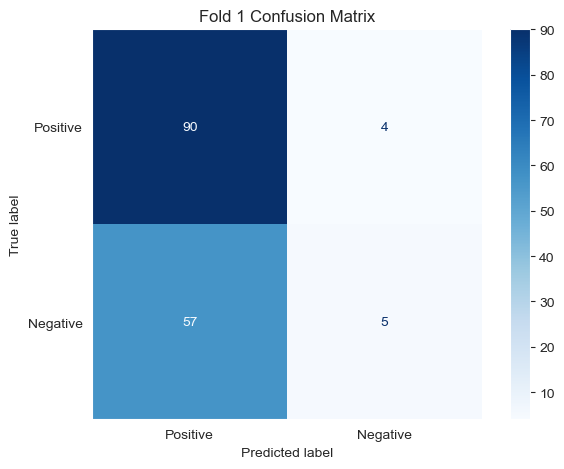

Fold 1:
[[48 35]
 [32 41]]


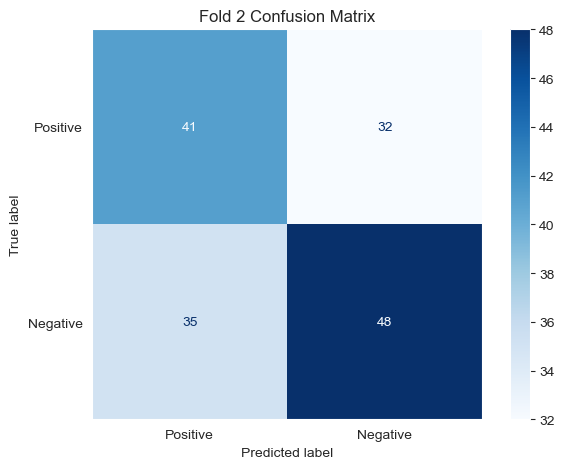

Fold 2:
[[37 36]
 [29 54]]


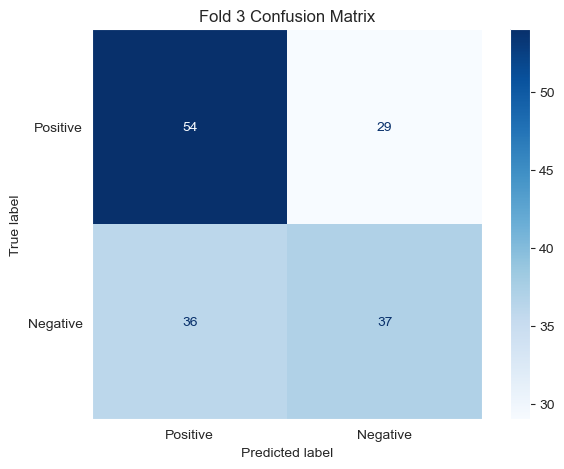

Fold 3:
[[24 51]
 [21 60]]


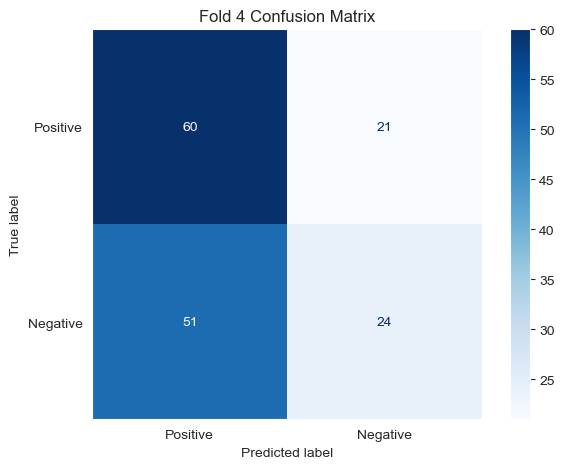

Fold 4:
[[43 26]
 [32 55]]


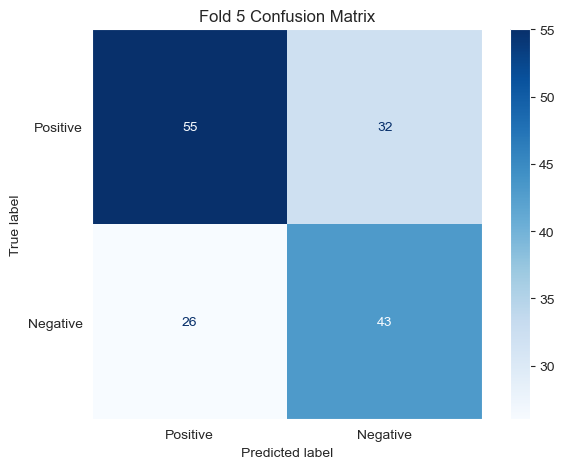

Fold 5:
[[49 23]
 [42 42]]


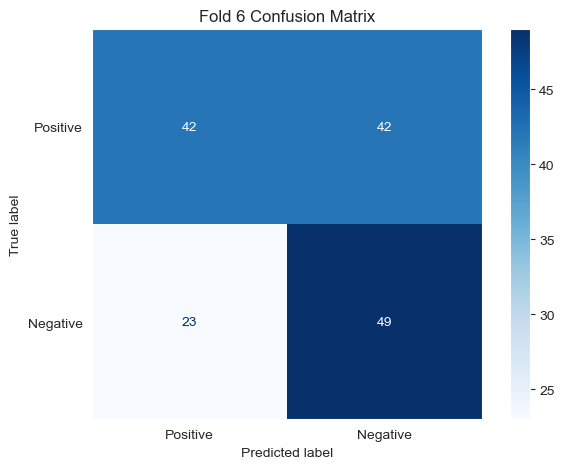

Fold 6:
[[30 39]
 [12 75]]


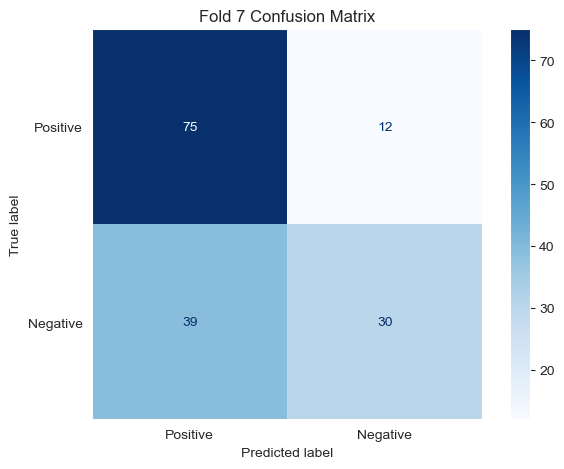

Fold 7:
[[38 30]
 [24 64]]


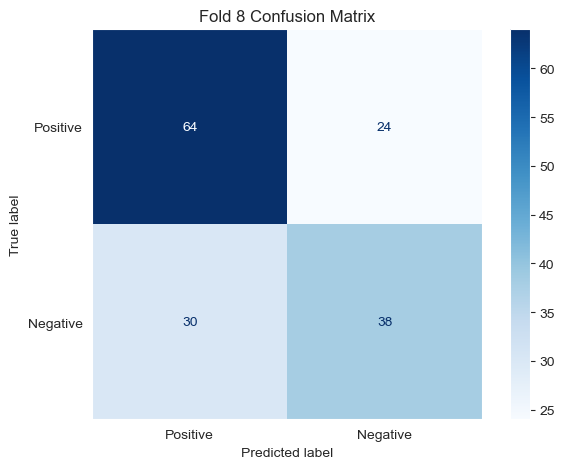

Fold 8:
[[58 17]
 [42 39]]


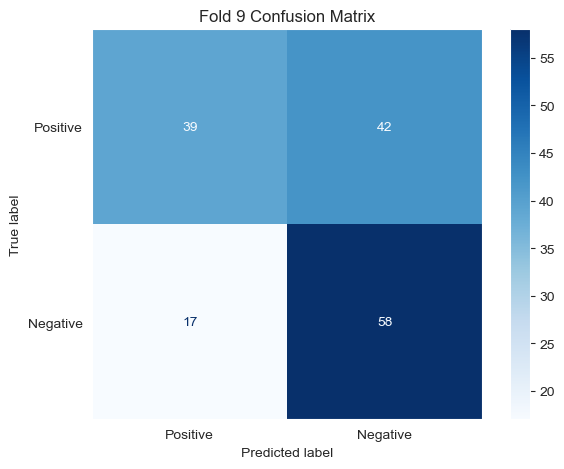

Fold 9:
[[50 27]
 [24 55]]


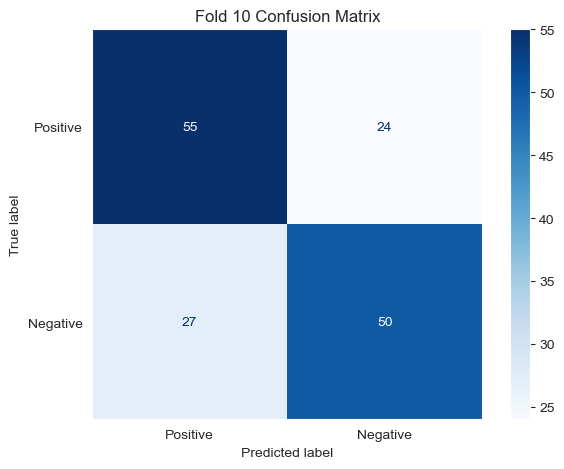

In [4]:
train_model(X, y, get_corr_matrix=True, save_conf_matrix=True)

In [5]:
season_year = "2023-24"
df = get_game_stats_data_df(season_year, training_and_testing=True)
X, y, home_ids = get_X_and_y(df)

get_game_stats_data.ipynb:81: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  "    features = [\n",


In [6]:
from sklearn.model_selection import TimeSeriesSplit
from scipy import stats
import os

def make_preds(X, y, verbose=False, get_conf_matrix_img=False, season_year="Test"):
    if X.shape[0] < 1:
        return None, None, None, None, None, None
    
    ensemble_probs = []
    ensemble_preds = []
    accs = []
    recalls = []
    pres = []
    f1s = []
    cms = []
    
    folder_path = 'fold_data'
    num_folds = len([f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))])
    for i in range(num_folds):
        fold = joblib.load(f'fold_data/ensemble_fold_{i}.pkl')
        X_test = X.copy()
        y_test = y.copy()
    
        X_test = X_test.reindex(columns=fold['feature_names_pre_drop'], fill_value=0)
        X_test = X_test.fillna(fold['mean'])
        X_test = pd.DataFrame(
            fold['scaler'].transform(X_test),
            columns=X_test.columns,
            index=X_test.index
        )
        X_test = X_test.drop(fold['dropped_features'], axis=1)
    
        probs = fold['model'].predict_proba(X_test)[:, 1]
        y_preds = (probs >= fold['best_threshold']).astype(int)
    
        ensemble_probs.append(probs)
        ensemble_preds.append(y_preds)
    
        acc = accuracy_score(y_test, y_preds)
        recall = recall_score(y_test, y_preds)
        precision = precision_score(y_test, y_preds)
        f1 = f1_score(y_test, y_preds)
        cm = confusion_matrix(y_test, y_preds, labels=[0, 1])
        accs.append(acc)
        recalls.append(recall)
        pres.append(precision)
        f1s.append(f1)
        cms.append(cm)
    
    ensemble_preds = [np.array(p).flatten() for p in ensemble_preds]
    preds_stack = np.vstack(ensemble_preds)
    final_preds = stats.mode(preds_stack, axis=0, keepdims=False).mode
    final_acc = accuracy_score(y, final_preds)
    final_recall = recall_score(y, final_preds, zero_division=0)
    final_precision = precision_score(y, final_preds, zero_division=0)
    final_f1 = f1_score(y, final_preds, zero_division=0)
    final_cm = confusion_matrix(y, final_preds, labels=[0, 1])

    if verbose:
        print("-" * 100)
        print(f"Accuracy: {final_acc:.4f}")
        print(f"Recall: {final_recall:.4f}")
        print(f"Precision: {final_precision:.4f}")
        print(f"F1 Score: {final_f1:.4f}")
        print("Confusion matrix:")
        print(final_cm)
        print("-" * 100)
        
    if get_conf_matrix_img:
        plot_save_confusion_matrix(final_cm, title_prefix=f"{season_year} Season ")

    return list(final_preds), final_acc, final_recall, final_precision, final_f1, final_cm

In [9]:
final_preds, final_acc, final_recall, final_precision, final_f1, final_cm = make_preds(X, y, verbose=True, get_conf_matrix_img=False, season_year=season_year)

C:\Users\gthra\AppData\Local\Temp\ipykernel_25752\1785655966.py:25: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_test = X_test.fillna(fold['mean'])
C:\Users\gthra\AppData\Local\Temp\ipykernel_25752\1785655966.py:25: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_test = X_test.fillna(fold['mean'])
C:\Users\gthra\AppData\Local\Temp\ipykernel_25752\1785655966.py:25: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the f

----------------------------------------------------------------------------------------------------
Accuracy: 0.6032
Recall: 0.7096
Precision: 0.6133
F1 Score: 0.6580
Confusion matrix:
[[454 493]
 [320 782]]
----------------------------------------------------------------------------------------------------
